# Language Complexity
This notebooks builds a simplified language complexity metric based on a *tf-idf* calculation for the \[mysql\] tagged questions and answers on Stack Overflow, and an external source *Wordfreq* for generalization.

In [ ]:
# Install required modules.
!pip install -r requirements.txt

In [1]:
import itertools
import math
import os
import re
import sys
from html.parser import HTMLParser
from io import StringIO

import database
import matplotlib.pyplot as plt
import mysql.connector
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordfreq

# from spacy.lang.en.examples import sentences
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import stop_words
from tqdm import tqdm

In [2]:
class StripHtml(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.text = StringIO()

    def handle_data(self, d) -> None:
        self.text.write(d)

    def get_data(self) -> bytes:
        return self.text.getvalue()


class CustomTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()

    def __call__(self, doc) -> list[str]:
        # Remove word contractions like can't and haven't.
        s = decontract(doc)
        # Original regex from sklearn https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d/sklearn/feature_extraction/text.py#L553.
        regex = r"(?u)\b\w\w+\b"
        # Apply regex to divide into words and lemmatize it.
        words = [self.wnl.lemmatize(word.lower()) for word in re.findall(regex, s)]

        # Remove numbers, words smaller than 3 characters, stop words and words with numeric values.
        words = [
            word
            for word in words
            if not word[0].isdigit()
            and len(word) >= 2
            and word not in stop_words.STOP_WORDS
            and re.search(r"[^a-zA-Z\s]+", word) is None
            and re.search(r"(.)\1{2,}", word) is None
        ]
        return words

In [24]:
# Initialize database for all mysql questions.
db_mysql = database.Database("stackoverflow_mysql")
# Initialize database for all mysql questions with SQL code samples.
db_mysql_with_samples = database.Database("stackoverflow")
# Initialize separate database for updating (since a generator-read might still be in use).
db_updater = database.Database("stackoverflow")

In [4]:
def store(function_df, store=None) -> pd.DataFrame:
    """
    Execute and save the function result if the pickle file does not exist.
    If it does exist, the pickle file is loaded.
    :param lambda function_df Function that returns a dataframe.
    :param string store
    """
    if store and os.path.exists(store):
        return pd.read_pickle(store)
    df = function_df()
    if store:
        df.to_pickle(store)
    return df


# Global functions
def strip_tags(text) -> bytes:
    """
    Strip HTML tags (and contents within HTML tags).
    """
    s = StripHtml()
    s.feed(text)
    return s.get_data()


def decontract(phrase) -> str:
    """
    Change forms like can't to cannot.
    """
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def tf_idf(texts) -> tuple:
    """
    Run tf-idf on a list of documents.
    """
    vectorizer = TfidfVectorizer(
        analyzer="word",
        norm="l2",
        strip_accents="unicode",
        encoding="utf-8",
        tokenizer=CustomTokenizer(),
        token_pattern=None,
    )
    X = vectorizer.fit_transform(texts)
    return X, vectorizer.get_feature_names_out()


def prepare_post_body(body, title=None, strip_html=True) -> str:
    """
    Do some preprocessing on a post body to filter out unwanted elements.
    :param string body
    :param string title Fallback text if the body appears to be empty.
    :param bool strip_html
    """
    if isinstance(body, bytes):
        # Decode to UTF-8.
        body = body.decode("utf-8")

    # Replace linefeed characters.
    body = body.replace("&#xA;", " ")
    # Remove dash remnants used for markup.
    body = re.sub(r"-{2,}", " ", body)
    # Remove all code samples and links.
    body = re.sub(r"<code>(.*?)</code>", "", body)
    body = re.sub(r"<pre>(.*?)</pre>", "", body)
    body = re.sub(r"<br>", "\n", body)

    # Remove all bold and italic fonted strings that only contain word characters (so are likely a single word).
    body = re.sub(r"<strong>(\w*?)</strong>", "", body)
    body = re.sub(r"<em>(\w*?)</em>", "", body)
    body = re.sub(r"<a.*?</a>", "", body)

    # Strip remaining HTML tags while keeping its contents.
    body = strip_tags(body) if strip_html else body
    # Remove newlines, tabs and double whitespaces.
    body = " ".join(body.split())
    # Cast to lowercase.
    body = body.lower()

    # Try title property if it is longer than the question body.
    if title is not None and (len(title) > len(body)):
        return prepare_post_body(title, title=None, strip_html=None)
    return body


def calculate_tfidf(texts, length=None, store=None) -> pd.DataFrame:
    """
    Apply tf-idf to a list of texts.
    :param generator texts: Expects a generator that returns tuples (id, body) for each row. This keeps it memory-efficient.
    :param int length: If given, a progress bar will be shown.
    """
    # Duplicate the iterator into two so we have IDs and bodies separately.
    ids, bodies = itertools.tee(texts)
    ids, bodies = (x[0] for x in ids), (y[1] for y in bodies)

    tfidf, words = tf_idf(tqdm(bodies, total=length))

    df = pd.DataFrame.sparse.from_spmatrix(data=tfidf, index=ids, columns=words)
    return df


def calculate_tfidf_for_query(query, length=None) -> pd.DataFrame:
    """
    Apply tf-idf from a query.
    :param str query: Query should return Id+PostBody.
    """
    bodies = ((row[0], prepare_post_body(row[1], row[2])) for row in db_mysql.query_generator(query))
    return calculate_tfidf(bodies, length=length)


def batch_generator(generator, batch_size):
    """
    Create batches for a generator.
    """
    while True:
        batch = list(itertools.islice(generator, batch_size))
        if not batch:
            break
        yield batch


def find_rows_with_nonzero_word(word) -> None:
    """
    Debugging function to find specific rows that have non-zero word values for a given word.
    """
    display(df_answers_tfidf[df_answers_tfidf[word] > 0.0])
    pass


def normalize(df) -> pd.DataFrame:
    """
    Min-max normalizer for a dataframe (maps values between 0 and 1).
    :param pandas.DataFrame df
    """
    return (df - df.min()) / (df.max() - df.min())


def most_common_words(df) -> pd.DataFrame:
    return df.sum(axis=0).sort_values(ascending=False)

In [6]:
# Use the complete posts and answers table (mysql tags) as input for the tf-idf calculation.
df_mysql_tfidf = store(
    lambda: calculate_tfidf_for_query(
        "SELECT Id, Body, Title FROM posts UNION ALL SELECT Id, Body, Title FROM answers",
        length=db_mysql.query("SELECT (SELECT COUNT(*) FROM posts) + (SELECT COUNT(*) FROM answers) FROM DUAL")[0][0],
    ),
    store="./pickle/df_mysql_tfidf.pickle",
)

display(df_mysql_tfidf)

,aa,aab,aaba,aabaco,aabb,aabbcc,aabbccdd,aabbccddeeff,aabcabac,aabehinnrvvx,...,zzempty,zzfisjmu,zzkt,zzl,zznabilss,zzodbc,zzproductdata,zzril,zztest,zzuse
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76399121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76399230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76399359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76399438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Remove words with less than 3 hits over the entire corpus. This filters out some of the typo's and randoms that should not have any value.
num_non_zero = df_mysql_tfidf.sparse.to_coo().getnnz(axis=0)
df_mysql_tfidf_filtered = store(
    lambda: df_mysql_tfidf[df_mysql_tfidf.columns[num_non_zero >= 3]],
    store="./pickle/df_mysql_tfidf_filtered.pickle",
)
display(df_mysql_tfidf_filtered)

,aa,aab,aaba,aabb,aac,aachen,aacute,aad,aadhaar,aae,...,zxjdbc,zxvf,zxy,zy,zygoteinit,zynga,zypper,zyx,zyxel,zz
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76399121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76399230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76399359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76399438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Retrieve average tf-idf for all words used in the SO mysql dataset.
s_common_mysql_words = df_mysql_tfidf_filtered.mean(axis=0)

# Retrieve a global wordlist from wordfreq based on 8 corpuses from different domains.
s_wordlist = pd.Series(wordfreq.get_frequency_dict("en", wordlist="large"))

In [9]:
display(s_common_mysql_words.sort_values(ascending=False).to_frame())
display(s_wordlist.sort_values(ascending=False).to_frame())

,0
table,4.006484e-02
query,3.698759e-02
use,3.548862e-02
try,3.010310e-02
like,2.858718e-02
...,...
doextract,1.639413e-08
implementationmethodexecutioninterceptor,1.636405e-08
repositoryfragments,1.636405e-08
weldclientproxy,1.450344e-08


,0
the,5.370318e-02
to,2.691535e-02
and,2.570396e-02
of,2.511886e-02
a,2.290868e-02
...,...
gialli,1.023293e-08
giay,1.023293e-08
gibbsite,1.023293e-08
gigamon,1.023293e-08


In [12]:
def calculate_word_complexity(s_input, s_external_input) -> pd.DataFrame:
    """
    Calculate the word complexity for all words in the given series.
    :param pandas.Series s_input MySQL tfidf
    :param pandas.Series s_external_input Wordfreq
    """
    a = s_input
    b = s_external_input
    # Filter out keys in the list b that are not in a.
    b = b[b.index.intersection(a.index)]

    # Normalize both series.
    a = normalize(a)
    b = normalize(b)

    dict = {key: (value, b.get(key) or 0) for (key, value) in a.items()}
    df = pd.DataFrame.from_dict(dict, orient="index", columns=["tf-idf", "word-frequency"])

    # Word complexity metric reasoning:
    # tf-idf (mysql)                 => 1 (high occurrence) => lower complexity
    # tf-idf (mysql)                 => 0 (low occurrence)  => higher complexity
    # word frequency (global)        => 1                   => lower complexity
    # word frequency (global)        => 0                   => higher complexity
    # 75% accounts for mysql, 25% for global wordfreq.
    df["complexity"] = (1 - df["tf-idf"]) * 0.5 + (1 - df["word-frequency"]) * 0.5
    return df

In [15]:
pd.set_option("display.float_format", lambda x: "%.6f" % x)
df_words = calculate_word_complexity(s_common_mysql_words, s_wordlist)

display(df_words.sort_values(by=["complexity"], ascending=False)[:10])
display(df_words.sort_values(by=["tf-idf"], ascending=False)[:10])
display(df_words.sort_values(by=["word-frequency"], ascending=False)[:10])

,tf-idf,word-frequency,complexity
resolvecandidate,0.000000,0.000000,1.000000
weldclientproxy,0.000000,0.000000,1.000000
repositoryfragments,0.000000,0.000000,1.000000
implementationmethodexecutioninterceptor,0.000000,0.000000,1.000000
doextract,0.000000,0.000000,1.000000
flushbeforetransactioncompletion,0.000000,0.000000,1.000000
invokeinourtx,0.000000,0.000000,1.000000
handlefirstrequest,0.000000,0.000000,1.000000
executeroothandler,0.000000,0.000000,1.000000
createwebapplicationcontext,0.000000,0.000000,1.000000


,tf-idf,word-frequency,complexity
table,1.000000,0.043648,0.478176
query,0.923193,0.001694,0.537556
use,0.885780,0.251186,0.431517
try,0.751360,0.123023,0.562809
like,0.713523,1.000000,0.143239
mysql,0.690878,0.000259,0.654432
database,0.548550,0.007939,0.721755
column,0.547219,0.008314,0.722234
want,0.544656,0.426577,0.514383
value,0.541947,0.054950,0.701551


,tf-idf,word-frequency,complexity
like,0.713523,1.000000,0.143239
time,0.280981,0.758577,0.480221
people,0.040520,0.691830,0.633825
new,0.205746,0.691830,0.551212
good,0.100384,0.512859,0.693379
know,0.227335,0.489777,0.641444
think,0.208929,0.467733,0.661669
want,0.544656,0.426577,0.514383
way,0.337469,0.398105,0.632213
said,0.041732,0.398105,0.780082


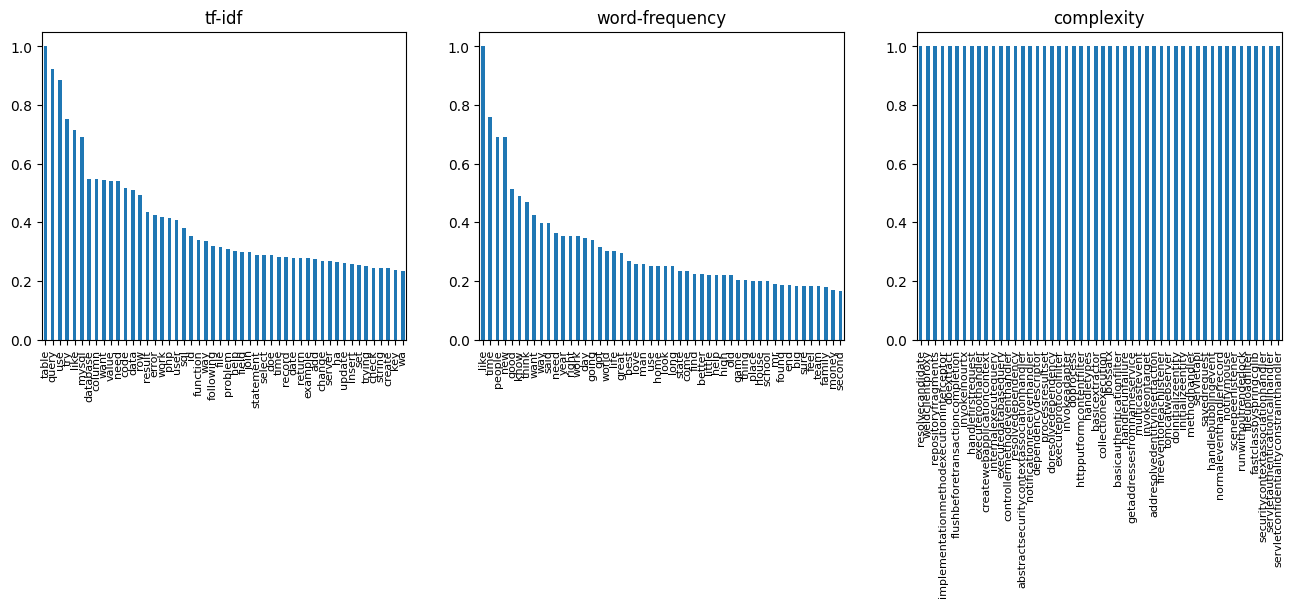

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))


def plot_figure(df, column, limit, x) -> None:
    ax = axes[x]
    ax.tick_params(axis="x", labelsize=8)
    df.sort_values(by=[column], ascending=False)[:limit][column].plot(kind="bar", title=column, ax=ax)
    pass


plot_figure(df_words, "tf-idf", 50, 0)
plot_figure(df_words, "word-frequency", 50, 1)
plot_figure(df_words, "complexity", 50, 2)

In [22]:
def calculate_language_complexity(text, text_fallback=None) -> tuple:
    """
    Calculate the language complexity score for a piece of text.
    :param string text
    :param string text_fallback Used if the first argument is empty after preparation (the fallback should be the question title).
    """
    prepared = prepare_post_body(text, text_fallback)
    tokenized = CustomTokenizer()(prepared)

    sum = df_words.reindex(tokenized)["complexity"].sum()
    word_count = len(prepared.split())
    token_count = len(set(tokenized))
    duplicate_words_compensation = max(1, math.log(word_count / token_count) if token_count > 0 else 0)
    # Divide by ln(word_count) to decrease the impact of long texts.
    complexity_score = sum if word_count <= 1 else (sum / duplicate_words_compensation)

    return complexity_score, word_count, prepared, tokenized


def calculate_language_complexity_for_row(row) -> tuple:
    """
    :param tuple row: Tuple with (Id, Body) as elements.
    """
    # Return 2 raw columns and 4 values from the complexity function.
    return (row[0], row[1]) + calculate_language_complexity(row[1], row[2])


def find_smallest_and_largest_complexities(query) -> pd.DataFrame:
    gen = (calculate_language_complexity_for_row(row) for row in db_mysql_with_samples.query_generator(query))
    gen = ((g[0], g[4], g[2]) for g in gen)
    df = pd.DataFrame(gen)
    df.columns = ["id", "text", "complexity"]
    df.set_index("id", inplace=True)
    return df


def prefill_features_table() -> None:
    db_updater.execute("INSERT IGNORE INTO features (QuestionId) SELECT Id FROM posts")
    pass


def populate_features_table(query, col_primary, col_1, col_2) -> None:
    """
    Populate wordcount and question complexity columns for the features table.
    """
    total = db_mysql_with_samples.query(query.copy() | {"SELECT": "COUNT(*)"})[0][0]

    with tqdm(total=total) as pbar:
        insertdata = (
            calculate_language_complexity_for_row(row) for row in db_mysql_with_samples.query_generator(query)
        )

        for row in insertdata:
            db_updater.execute(
                "UPDATE features SET {} = {}, {} = {} WHERE {} = {}; ".format(
                    col_1, row[2], col_2, row[3], col_primary, row[0]
                )
            )
            pbar.update(1)
        pbar.close()
    pass

In [18]:
tests = [
    "have nothing to do but make a table query \n have nothing to do but make a table query \n have nothing to do but make a table query",
    "have nothing to do but make a table query",
    "extraterrestrial idiomatic calculation runge-kutta curve",
    "I am trying to SELECT WHERE IN SELECT, what I am I doing wrong?",
]

display(
    pd.DataFrame(
        [calculate_language_complexity(t) for t in tests], columns=["Complexity", "# words", "Document", "Tokenized"]
    )
)

,Complexity,# words,Document,Tokenized
0,1.170788,27,have nothing to do but make a table query have...,"[table, query, table, query, table, query]"
1,0.675319,9,have nothing to do but make a table query,"[table, query]"
2,2.985234,5,extraterrestrial idiomatic calculation runge-k...,"[extraterrestrial, idiomatic, calculation, run..."
3,2.203503,14,"i am trying to select where in select, what i ...","[trying, select, select, wrong]"


In [19]:
df_smallest_and_largest_language_complexities = store(
    lambda: find_smallest_and_largest_complexities(
        {
            "SELECT": "Id, Body, Title",
            "FROM": "posts",
        }
    ),
    store="./pickle/df_smallest_and_largest_language_complexities.pickle",
)
display(df_smallest_and_largest_language_complexities.nlargest(10, "complexity")[["text", "complexity"]])
display(df_smallest_and_largest_language_complexities.nsmallest(10, "complexity")[["text", "complexity"]])

,text,complexity
id,,
52202759,we have a mysql slave in production that gets ...,734.283148
59791225,recent discovery among everything else i tried...,373.607671
58012844,i've got a very specifc and quite complex need...,280.063829
68960624,this is really confusing me. i have many diffe...,268.287906
50810528,i have this table structure exercises from whe...,266.337199
40890489,i'm running a mysql query using php and pdo. s...,264.089470
40520162,"in summary, date range partitioning and memory...",251.851227
49640973,"nb: i could have used a dictionary like , or b...",245.854538
10047760,my team working on a php/mysql website for a s...,226.484062


,text,complexity
id,,
67721718,this is what it shows me this is what i want y...,0.179045
31269962,below is the query. how this query can be ?,0.266815
50367595,"if "" do that price if there is a doing nothing...",0.327859
46193701,i want to make this and this is my query what ...,0.370103
51724529,what is the meaning of this 'where (1) in'?,0.446087
49621277,how do you do this in laravel 5.5?,0.462980
9921651,how can i make this in doctrine 1.2?,0.475262
7700630,why when i have records like (): then: gives: ...,0.475562
47494053,but my with a and an gives me an empty result....,0.495331


In [20]:
# prefill_features_table()
populate_features_table(
    {
        "SELECT": "Id, Body, Title",
        "FROM": "posts",
    },
    "QuestionId",
    "QuestionLanguageComplexity",
    "QuestionWordCount",
)

100%|███████████████████████████████████████████████████████████████████████████| 94925/94925 [05:23<00:00, 292.98it/s]


In [25]:
populate_features_table(
    {
        "SELECT": "Id, Body, Title",
        "FROM": "answers",
    },
    "AnswerId",
    "AnswerLanguageComplexity",
    "AnswerWordCount",
)

100%|██████████████████████████████████████████████████████████████████████| 1048160/1048160 [14:53<00:00, 1172.78it/s]
